## Problem Set 05
### AST 8110, Fall 2022
##### Tyler Barna

In [1]:
## Importing packages (some of these may not be useful)
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import time
#bigstart = time.time()


import sys
import os
import astropy
import astropy.units as u
import astropy.constants as const
import astropy.coordinates as coord
import random

from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from numpy.linalg import norm ## to calculate magnitude of vector

from tqdm import tqdm
from scipy import meshgrid
from scipy.stats import binned_statistic as binstat
from scipy.integrate import quad, dblquad ## to integrate
from scipy.signal import argrelextrema as extrema 

#%matplotlib inline
mpl.rcParams.update({"axes.grid" : True})
plt.style.context(("seaborn-colorblind",))
#plt.rc("text", usetex=True)
#plt.rc("font", family="serif")

## Set Seed
random.seed(8110)

### Problem 1

From class, we know that the absolute magnification is given by

$$
\begin{equation}
J = \left(A_1 + A_2\right) I = \frac{u^2 +2}{u\left( u^2 + 4\right)^{1/2}} I
\end{equation}
$$

for  $u=\frac{\beta}{\theta_E}$ . $b$ is the distance of closest approach between the source and the lens. In problem one, $I=1$, so the magnification becomes simply

$$
\begin{equation}
J = \frac{u^2 +2}{u\left( u^2 + 4\right)^{1/2}}
\end{equation}
$$

If we evaluate in units of $\theta_E$, we can directly substitute $u$ with $\beta$. The magnification is then given by

$$
\begin{equation}
J = \frac{\beta^2 +2}{\beta\left( \beta^2 + 4\right)^{1/2}}
\end{equation}
$$

$\beta$ can be found using trigonometry $\beta^2 = x^2 + y^2$. The magnification is then given by

$$
\begin{equation}
x = p + r \text{cos}(\theta), \ \ \ \ \ 

y = b + r \text{sin}(\theta)
\end{equation}
$$

So to find the magnification, we do the integral

$$
\begin{equation}
J = \int_{0}^{2\pi} \int_{0}^{r_0} r dr d\theta \frac{\beta^2\left(r,\theta,p\right) +2}{\beta\left(r,\theta,p\right)\left( \beta^2\left(r,\theta,p\right) + 4\right)^{1/2}} 
\end{equation}
$$

where $\beta^2\left(r,\theta,p\right) = \left(p + r \text{cos}(\theta)\right)^2 + \left(b + r \text{sin}(\theta)\right)^2$.

(a) $r_0=1.0$, $b=1.5$

(b) $r_0=0.2$, $b=1.5$

(c) $r_0=1.0$, $b=0.1$

(d) $r_0=0.2$, $b=0.1$

In [107]:
## define function to calculate magnification
def lc(r0,b,p,dark=False):
    #u = np.sqrt
    x = lambda r, theta, p: p + r * np.cos(theta)
    y = lambda r, theta, b: b + r * np.sin(theta)
    if not dark:
        beta = lambda r, theta, b, p: np.linalg.norm([p + r * np.cos(theta), 
                                                    b + r * np.sin(theta)])
    elif dark:
        beta = lambda r, theta, b, p: np.linalg.norm([p + r * (1 - 0.5 * (1 - np.sqrt(1 - r**2))) * np.cos(theta), 
                                                    b + r * (1 - 0.5 * (1 - np.sqrt(1 - r**2))) * np.sin(theta)]) #/ (1 - 0.5 * (1 - np.sqrt(1 - r**2)))
    
    if not dark:
        integral = lambda r, theta, b, p: r * (beta(r, theta, b, p)**2 +2)/(beta(r, theta, b, p) * np.sqrt(beta(r, theta, b, p)**2 + 4))
    
    elif dark:
        limb = lambda r: 1 - 0.5 * (1 - np.sqrt(1 - r**2))
        integral = lambda r, theta, b, p:  r * (beta(r, theta, b, p)**2 +2)/(beta(r, theta, b, p) * np.sqrt(beta(r, theta, b, p)**2 + 4)) #* limb(r)
        #integral = lambda r, theta, b, p: integral(r, theta, b, p) * limb(r)
    
    curve = lambda p: dblquad(integral, 
                              0, np.pi, 
                              0, r0, 
                              args=(b, p),
                              epsrel=5)[0] 
    curve = np.vectorize(curve)
    curveVal = 2* curve(p) /(np.pi * r0**2)
    #curve = map(lambda x: 2*x/(np.pi*r0**2), curve(p))
    return curveVal

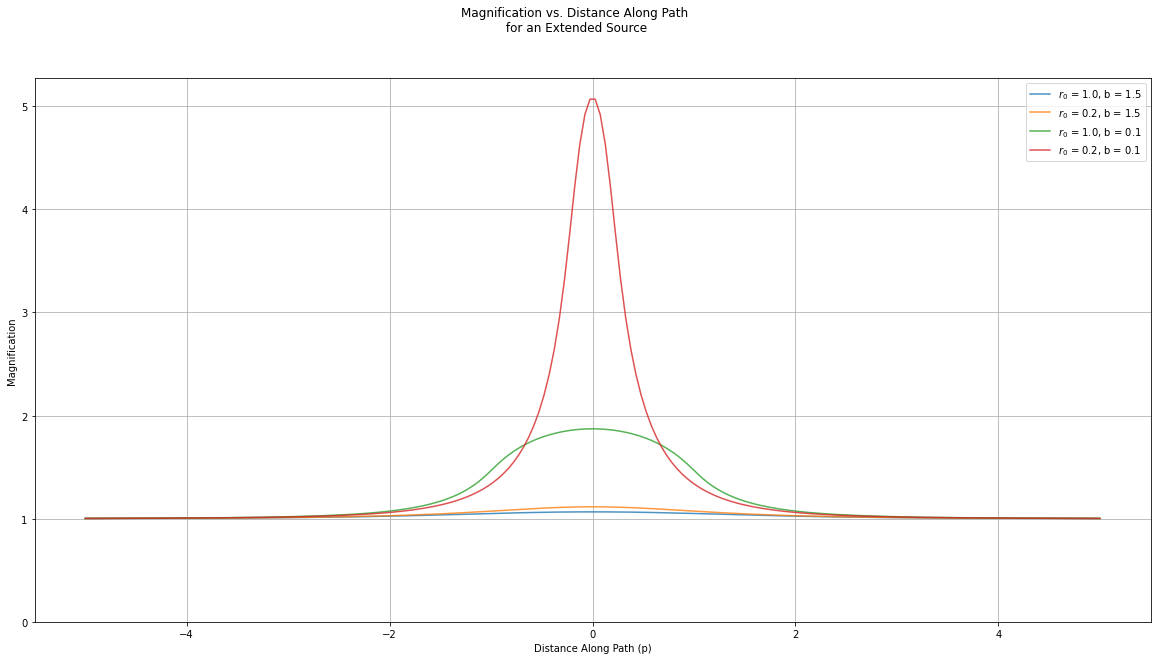

In [103]:
## define parameters
r0 = [1.0,0.2,1.0,0.2]
b = [1.5,1.5,0.1,0.1]
p = np.linspace(-5,5,200)

## plot the lightcurves
fig, ax = plt.subplots(1,1,figsize=(20,10), facecolor="white")

#for r0, b in zip(r0,b):

mag = [lc(r0=r0,b=b,p=p,dark=False) for r0, b in zip(r0,b)]
    
[sns.lineplot(x=p, y=mlc,
                alpha=0.8,
                label=r'$r_0$ = {}, b = {}'.format(r0,b), ax = ax)
 for mlc, r0, b in zip(mag, r0, b)]
fig.suptitle('Magnification vs. Distance Along Path\n for an Extended Source')
ax.set_xlabel('Distance Along Path (p)')
ax.set_ylabel('Magnification')
ax.set_ylim(0,)
plt.show();

### Problem 2

Modify to include limb darkening, given by

$$
\begin{equation}
I\left(r\right) \propto 1 - u \left(1- \sqrt{1-r^2}\right)
\end{equation}
$$

From the assignment, we should take the parameters of 1c, so $r_0=1.0$ and $b=0.1$. We can then use the same equation as before, but with the new intensity function. 

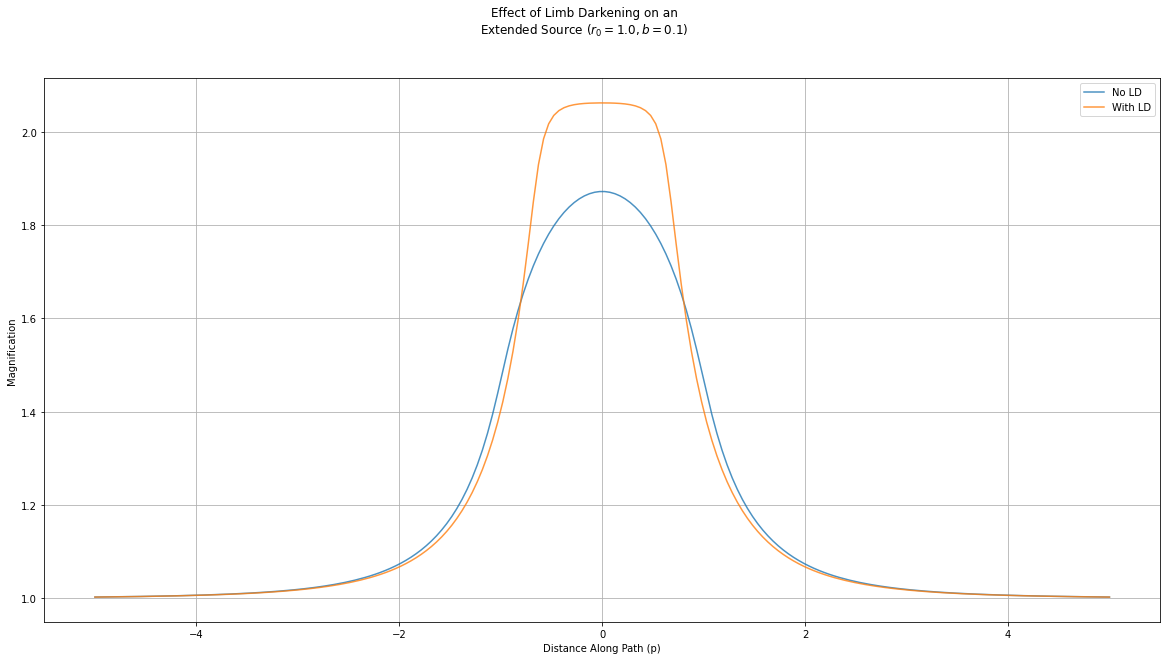

In [108]:
## plot the lightcurves
fig, ax = plt.subplots(1,1,figsize=(20,10))
for dBool in [False, True]:
    
    plotLabel = 'No LD' if not dBool else 'With LD'
    
    sns.lineplot(x=p, y=lc(r0=1.0,b=0.1,p=p,dark=dBool),
                 alpha=0.8,
                 label=plotLabel, ax = ax)
fig.suptitle('Effect of Limb Darkening on an\n'+r'Extended Source ($r_0=1.0,b=0.1$)')
ax.set_xlabel('Distance Along Path (p)')
ax.set_ylabel('Magnification')
plt.show();

With limb darkening, the magnification curve is narrower, which would correspond more closely to a point source